In [1]:
import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image, ImageDraw

In [2]:
try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # no problem, let's use OpenAI gym's rendering function
except Exception:
    openai_cart_pole_rendering = False  # probably no X server available, let's use our own rendering function

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # use OpenAI gym's rendering function
        return env.render(mode="rgb_array")
    else:
        # rendering for the cart pole environment (in case OpenAI gym can't do it)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [3]:
env = gym.make("CartPole-v0")
obs = env.reset()
obs

array([-0.01206774,  0.03276225, -0.00039932, -0.03195472])

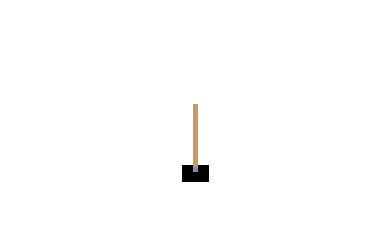

In [7]:
# img = env.render(mode="rgb_array")
# img
plot_cart_pole(env, obs)

In [3]:
env.action_space

Discrete(2)

In [8]:
action = 1
obs, reward, done, info = env.step(action)

In [9]:
obs #obs[0] 小推车水平位置 obs[1] 速度 obs[2] 杆的角度  obs[3] 角速度

array([-0.01141249,  0.22788993, -0.00103841, -0.3247636 ])

In [10]:
reward

1.0

In [11]:
done

False

In [12]:
info

{}

In [13]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

In [14]:
obs = [1, 2, 1, 0]
basic_policy(obs)

1

In [15]:
totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(1000):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [16]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.23, 9.029346598730164, 24.0, 72.0)

# 神经网络策略

In [3]:
tf.reset_default_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=(None, n_inputs))

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu,
                         kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits)

p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
"""
从multinomial分布 中采样，样本个数是num_samples，每个样本被采样的概率由logits给出
tf.multinomial(logits, 
               num_samples, 
               seed=None, 
               name=None)
"""
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

y = 1 - tf.to_float(action)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))

training_op = optimizer.apply_gradients(grads_and_vars=grads_and_vars_feed)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [36]:
gradient_placeholders

[<tf.Tensor 'Placeholder_1:0' shape=(4, 4) dtype=float32>,
 <tf.Tensor 'Placeholder_2:0' shape=(4,) dtype=float32>,
 <tf.Tensor 'Placeholder_3:0' shape=(4, 1) dtype=float32>,
 <tf.Tensor 'Placeholder_4:0' shape=(1,) dtype=float32>]

In [37]:
grads_and_vars_feed

[(<tf.Tensor 'Placeholder_1:0' shape=(4, 4) dtype=float32>,
  <tf.Variable 'dense/kernel:0' shape=(4, 4) dtype=float32_ref>),
 (<tf.Tensor 'Placeholder_2:0' shape=(4,) dtype=float32>,
  <tf.Variable 'dense/bias:0' shape=(4,) dtype=float32_ref>),
 (<tf.Tensor 'Placeholder_3:0' shape=(4, 1) dtype=float32>,
  <tf.Variable 'dense_1/kernel:0' shape=(4, 1) dtype=float32_ref>),
 (<tf.Tensor 'Placeholder_4:0' shape=(1,) dtype=float32>,
  <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32_ref>)]

In [4]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]

In [31]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

In [32]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [38]:
env = gym.make("CartPole-v0")

n_games_per_update = 10
n_max_steps = 1000
n_iterations = 250
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\rIteration: {}".format(iteration), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients],
                                                     feed_dict={X: obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
        
        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./model/policy_gradients.ckpt")

Iteration: 249

In [39]:
env.close()

In [8]:
n_max_steps = 1000
frames = []
env = gym.make("CartPole-v0")
obs = env.reset()
with tf.Session() as sess:
    saver.restore(sess, "./model/policy_gradients.ckpt")
    for step in range(n_max_steps):
        img = render_cart_pole(env, obs)
        frames.append(img)
        action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
        obs, reward, done, info = env.step(action_val[0][0])
        if done:
            break
env.close()

INFO:tensorflow:Restoring parameters from ./model/policy_gradients.ckpt


# 马尔可夫决策过程

In [14]:
nan = np.nan
T = np.array([ # T(s, a, sp)是假设代理选择行为a, 从状态s到状态sp的转移概率
                            [[0.7, 0.3, 0.0],   [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
#s0状态下选择行为a0的转移概率    s0   s1   s2  a1:  s0   s1   s2 a2: s0   s1   s2 
    [[0.0, 1.0, 0.0], [nan, nan, nan], [0.0, 0.0, 1.0]],
    [[nan, nan, nan], [0.8, 0.1, 0.1], [nan, nan, nan]],
])
R = np.array([ # R(s, a, sp)是假设代理选择行为a, 从状态s到状态sp获得的回报
    [[10., 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]],
    [[10., 0.0, 0.0], [nan, nan, nan], [0.0, 0.0, -50.]],
    [[nan, nan, nan], [40., 0.0, 0.0], [nan, nan, nan]],
])
possible_actions = [[0, 1, 2], [0, 2], [1]]  #每个状态下可能选择的行为 0: a0  1: a1  2: a2

### Q值迭代算法

In [17]:
Q = np.full((3, 3), -np.inf)
Q

array([[-inf, -inf, -inf],
       [-inf, -inf, -inf],
       [-inf, -inf, -inf]])

In [18]:
for state, actions in enumerate(possible_actions):
    print(state, actions)
    Q[state, actions] = 0.0
Q #最优Q值是Q(s, a)是代理到达状态s并选择了行为a后，假设在此行为后行为最优，预期的平均折扣后未来回报的总和
# 状态s2不能选择行为a1: inf  状态s3不能选择行为a0 a2

0 [0, 1, 2]
1 [0, 2]
2 [1]


array([[  0.,   0.,   0.],
       [  0., -inf,   0.],
       [-inf,   0., -inf]])

In [19]:
learning_rate = 0.01
discount_rate = 0.95
n_iterations = 1000

for iteration in range(n_iterations):
    Q_prev = Q.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q[s, a] = np.sum([
                T[s, a, sp] * (R[s, a, sp] + discount_rate * np.max(Q_prev[sp]))
                for sp in range(3)
            ])
Q

array([[21.89925005, 20.80428755, 16.86759588],
       [ 1.12082922,        -inf,  1.17982024],
       [       -inf, 53.87349498,        -inf]])

# Q-learning

In [24]:
import numpy.random as rnd

learning_rate0 = 0.05
learning_rate_decay = 0.1
discount_rate = 0.95
n_iterations = 20000

R = np.array([ # R(s, a, sp)是假设代理选择行为a, 从状态s到状态sp获得的回报
    [[10., 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]],
    [[10., 0.0, 0.0], [nan, nan, nan], [0.0, 0.0, -50.]],
    [[nan, nan, nan], [40., 0.0, 0.0], [nan, nan, nan]],
])

Q = np.full((3, 3), -np.inf)
possible_actions = [[0, 1, 2], [0, 2], [1]]  #每个状态下可能选择的行为 0: a0  1: a1  2: a2
for state, actions in enumerate(possible_actions):
    Q[state, actions] = 0.0
Q

array([[  0.,   0.,   0.],
       [  0., -inf,   0.],
       [-inf,   0., -inf]])

In [25]:
s = 0

for iteration in range(n_iterations):
    a = rnd.choice(possible_actions[s])
    sp = rnd.choice(range(3), p=T[s, a])
    reward = R[s, a, sp]
    learning_rate = learning_rate0 / (1 + iteration * learning_rate_decay)
    Q[s, a] = learning_rate * Q[s, a] + (1 - learning_rate) * (reward + discount_rate * np.max(Q[sp]))
    s = sp
    
Q

array([[129.22709332, 121.58217041,  95.07921838],
       [ 95.07852648,         -inf, 100.08265945],
       [        -inf, 155.50312384,         -inf]])

# 使用DQN学习玩吃豆人

In [26]:
env = gym.make("MsPacman-v0")
obs = env.reset()
obs.shape

(210, 160, 3)

In [27]:
env.action_space

Discrete(9)

In [30]:
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2]
    img = img.sum(axis=2)
    img[img == mspacman_color] = 0
    img = (img // 3 - 128).astype(np.int8)
    return img.reshape(88, 80, 1)

img = preprocess_observation(obs)

In [31]:
img.shape

(88, 80, 1)

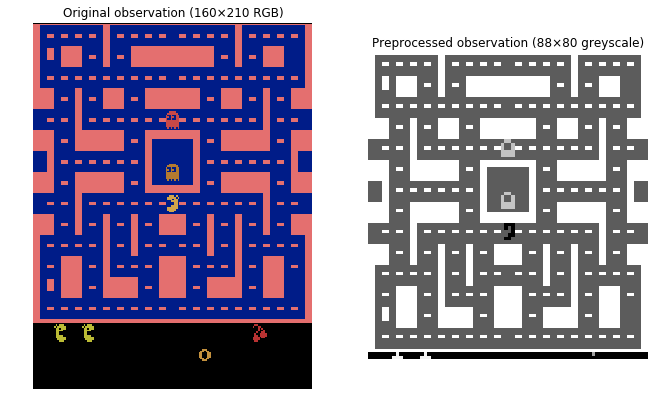

In [33]:
plt.figure(figsize=(11, 7))

plt.subplot(1, 2, 1)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Preprocessed observation (88×80 greyscale)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")

plt.show()

In [34]:
tf.reset_default_graph()

input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_size = [(8, 8), (4, 4), (3, 3)]
conv_strides = [4, 2, 1]
conv_padding = ["SAME"] * 3
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n